## Dataset download

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2020-10-11 11:59:14--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.7MB/s    in 36s     

2020-10-11 11:59:51 (21.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!tar -xf images.tar.gz

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-10-11 11:59:58--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.3MB/s    in 1.8s    

2020-10-11 12:00:00 (10.3 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
!tar -xf annotations.tar.gz

In [ ]:
ls "./annotations/"

list.txt  README  test.txt  trainval.txt  trimaps/  xmls/


In [ ]:

import os
import pandas as pd
from lxml import etree 
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 
%matplotlib inline
import csv
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape, Dense, concatenate, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy, Huber

## Data pre-processing and preparation

In [ ]:
xmlfiles = os.listdir("./annotations/xmls")

In [ ]:
# getting bounding box annotations from xml files
anno_data = [['filename','class','xmin','xmax','ymin','ymax']]
for xmlfile in xmlfiles:
    im_data = []
    with open("./annotations/xmls/{}".format(xmlfile)) as xml_file:
        xml = xml_file.read()
    root = etree.fromstring(xml)
    im_data.append(root.find("./filename").text) # image name
    if root.find("./object/name").text == 'cat': # image onverted to binary; Dog:1, Cat:0
        im_data.append(0)
    else:
        im_data.append(1)
    # bbox cordinates: xmin, xmax, ymin, ymax
    # scaling cordinates for an image size of (224, 224)
    im_data.append(int(int(root.find("./object/bndbox/xmin").text) * 224/int(root.find("./size/width").text))) 
    im_data.append(int(int(root.find("./object/bndbox/xmax").text) * 224/int(root.find("./size/width").text)))
    im_data.append(int(int(root.find("./object/bndbox/ymin").text) * 224/int(root.find("./size/height").text)))
    im_data.append(int(int(root.find("./object/bndbox/ymax").text) * 224/int(root.find("./size/height").text)))
    anno_data.append(im_data)

In [ ]:
# saving annotation list to csv file
file = open('f_annotation.csv', 'w+', newline ='')
with file:     
    write = csv.writer(file) 
    write.writerows(anno_data) 

## Data vizualization

In [ ]:
def draw_rectangle(im_path, x0,x1,y0,y1):
  """Draws a groundtruth bounding box given an image path an cordinates"""
  im = Image.open(im_path)
  img = ImageDraw.Draw(im)
  img.rectangle([x0*im.width/224,y0*im.height/224, x1*im.width/224,y1*im.height/224], outline="green") #rescaling cordinates for actual image

  plt.imshow(im)

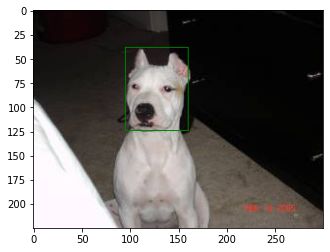

In [ ]:
draw_rectangle("./images/"+anno_data[15][0], anno_data[15][2], anno_data[15][3], anno_data[15][4], anno_data[15][5])

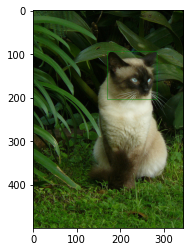

In [ ]:
draw_rectangle("./images/"+anno_data[157][0], anno_data[157][2], anno_data[157][3], anno_data[157][4], anno_data[157][5])

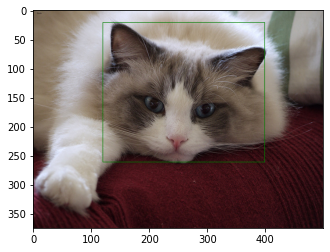

In [ ]:
draw_rectangle("./images/"+anno_data[1157][0], anno_data[1157][2], anno_data[1157][3], anno_data[1157][4], anno_data[1157][5])

## Building data pipeline for training

1. creating dataframe object from prepared list
2. train-test split
3. creating data-generator object for training

In [ ]:
# creating dataframe from "anno_data" list
df = pd.DataFrame(anno_data[1:], columns= ['filename','class','xmin','xmax','ymin','ymax'])

In [ ]:
df.head()

,filename,class,xmin,xmax,ymin,ymax
0,Bengal_184.jpg,0,133,169,61,110
1,basset_hound_185.jpg,1,83,143,76,152
2,Sphynx_12.jpg,0,53,135,14,138
3,Egyptian_Mau_146.jpg,0,158,209,142,196
4,newfoundland_146.jpg,1,100,186,28,90


In [ ]:
# Train test split
traindf, testdf = train_test_split(df, test_size=0.1)

In [ ]:
len(traindf)

3317

In [ ]:
# creating data-generator object for training
out_clms = ['class','xmin','xmax','ymin','ymax']

# not normalizing as we are required to use specific preprocessing for MobileNetV2
datagen=ImageDataGenerator()
test_datagen=ImageDataGenerator()

train_generator=datagen.flow_from_dataframe(
    dataframe=traindf[:3000],
    directory="./images",
    x_col="filename",
    y_col=out_clms,
    batch_size=32,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf[3000:],
    directory="./images",
    x_col="filename",
    y_col=out_clms,
    batch_size=32,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224,224))


test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="./images",
    x_col="filename",
    batch_size=1,
    seed=123,
    shuffle=False,
    class_mode=None,
    target_size=(224,224))

Found 3000 validated image filenames.
Found 317 validated image filenames.
Found 369 validated image filenames.


## Modeling and training

In [ ]:
def create_model():
  
  i = tf.keras.layers.Input([224, 224, 3], dtype = tf.uint8) # input layer: image array with value2 [0,255]
  x = tf.cast(i, tf.float32) 
  x = preprocess_input(x) # preprocessing layer for MobileNetV2
  mnv2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, alpha=0.75)
  mdl = mnv2(x)

  xp = GlobalAveragePooling2D()(mdl)
  xp = Dropout(0.75)(xp)
  # above is the shared part of model for both tasks
  # below is the model for bounding box prediction task (regression)
  x1 = Dense(128, activation='relu')(xp)
  x1 = Dropout(0.5)(x1)
  x1 = Dense(4, activation='relu')(x1)

  #below is the model for class prediction (probalistic)
  x2 = Dense(128, activation='relu')(xp)
  x2 = Dense(1, activation='sigmoid')(x2)

  # combining the both outputs  
  outp = concatenate([x2, x1])
  return Model(inputs=[i], outputs=[outp])


model = create_model()
model.summary()

5906432/5903360 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 224, 224, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           tf_op_layer_Cast[0][0]           
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 224, 224, 3) 0           tf_op_layer_RealDiv[0][0]        
________________________

In [ ]:
# custom loss function
# classification task: binary crossentropy loss
# cordinates prediction: Huber loss
# Huber is the blend of MSE and MAE, less sensitive to outliers
# learn more: https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

def entropy_weighted_Huber(y_actual, y_predicted):
  bce = BinaryCrossentropy()
  hub = Huber(delta=1.5)
  return bce(y_actual[0][0], y_predicted[0]) + hub(y_actual[1:], y_predicted[1:])

In [ ]:
# model compilation
model.compile(optimizers.Adam(0.00003),loss=entropy_weighted_Huber)

In [ ]:
# Training for 180 epochs with smaller leraning rate, i.e. 0.00003
model.fit_generator(generator=train_generator,
                    validation_data = valid_generator,
                    epochs=180,verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/180
94/94 [==============================] - 22s 234ms/step - loss: 117.7683 - val_loss: 116.9160
Epoch 2/180
94/94 [==============================] - 21s 222ms/step - loss: 115.7595 - val_loss: 117.2448
Epoch 3/180
94/94 [==============================] - 21s 222ms/step - loss: 113.3651 - val_loss: 120.2705
Epoch 4/180
94/94 [==============================] - 21s 224ms/step - loss: 110.5291 - val_loss: 109.5800
Epoch 5/180
94/94 [==============================] - 21s 226ms/step - loss: 107.8561 - val_loss: 108.8351
Epoch 6/180
94/94 [==============================] - 21s 224ms/step - loss: 104.4351 - val_loss: 101.4216
Epoch 7/180
94/94 [==============================] - 21s 224ms/step - loss: 99.5780 - val_loss: 98.6632
Epoch 8/180
94/94 [==============================] - 21s 225ms/step - loss: 94.0025 - val_loss: 85.5893
Epoch 9/180
94/94 [==============================] - 21s 223ms/step - loss: 86.8

## Performance on test dataset

1. Classification accuracy
2. Classification accuracy with IoU greater than 0.5

In [ ]:
#ref: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def get_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	xB = min(boxA[1], boxB[1])
	yA = max(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
	boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
tpred = 0
tpredIoU05 = 0
for imd in testdf.values:
  pred = model.predict(np.expand_dims(np.asarray(Image.open("./images/"+imd[0]).resize((224,224))), axis=0))
  # check whether the prediction is right
  if (pred[0][0] >0.5).astype(int) == imd[1]:
    tpred += 1
    # check whether the iou value is greater than 0.5
    if get_iou(imd[2:], pred[0][1:]) > 0.5:
      tpredIoU05 += 1
    

In [ ]:
print("Classification accuracy on test data: {0:.2f}%".format(tpred*100/369))
print("Classification accuracy with IoU greater than 0.5 on test data: {0:.2f}%".format(tpredIoU05*100/369))

Classification accuracy on test data: 95.39%
Classification accuracy with IoU greater than 0.5 on test data: 88.89%


## Vizualization with model prediction

In [ ]:
def draw_rectangle2(im_data_row, model):
    """ im_data_row: list object of [filename, class, xmin, xmax, ymin, ymax], same as in anno_data list
    model: trained model object for the task
    """
    im = Image.open("./images/"+im_data_row[0])
    img = ImageDraw.Draw(im)
    # predict on the image
    pred = model.predict(np.expand_dims(np.asarray(Image.open("./images/"+im_data_row[0]).resize((224,224))), axis=0))
    pclass = "Dog" if pred[0][0] > 0.5 else "Cat"
    aclass = "Dog" if im_data_row[1] > 0.5 else "Cat"
    # draw ground truth bounding box in green
    img.rectangle([im_data_row[2]*im.width/224,im_data_row[4]*im.height/224, im_data_row[3]*im.width/224,im_data_row[5]*im.height/224], outline="green")
    # draw predicted bounding box in red
    img.rectangle([pred[0][1]*im.width/224,pred[0][3]*im.height/224, pred[0][2]*im.width/224,pred[0][4]*im.height/224], outline="red")
    # title: actual class and predicted class
    plt.title("Actual class: "+aclass+"; Predicted class: "+pclass)
    plt.imshow(im)

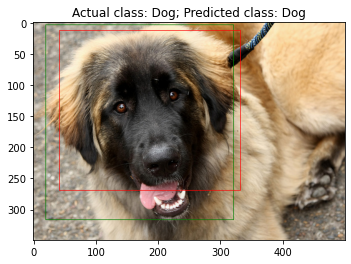

In [ ]:
draw_rectangle2(testdf.values[3], model= model)

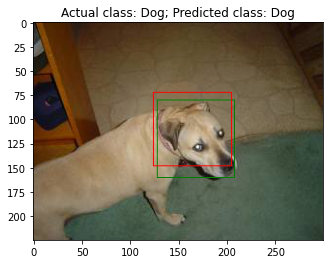

In [ ]:
draw_rectangle2(testdf.values[33],model)

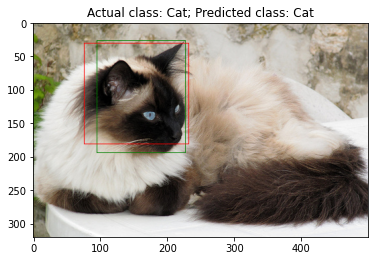

In [ ]:
draw_rectangle2(testdf.values[133],model)

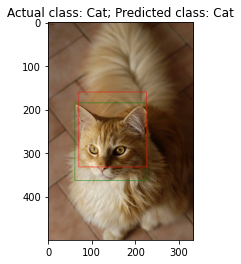

In [ ]:
draw_rectangle2(testdf.values[149],model)